### HVS Orbit Integration in a Dynamic MW+LMC Potential
This notebook performs a backward orbit integration for every Hypervelocity Star (HVS) using a time-varying gravitational potential that accounts for the motion of both the Milky Way (MW) and the Large Magellanic Cloud (LMC).

* **Data Loading:**
    * Loads the pre-processed 6D Cartesian phase-space data for the HVS sample.
    * Loads the center-of-mass orbital trajectories for both the MW and LMC, as derived from the Garavito-Camargo et al. (2019) simulations.

* **Potential & Integration:**
    * Imports the custom `MWPotential` class, which has been configured to use the MW and LMC orbital data to create a time-dependent potential.
    * Integrates the orbit of the HVS backward in time for 400 Myr using leapfrog integrator that handles the time-varying acceleration.
* **Analysys:**
    * Computes and displays closest approach to MW and LMC using sampled initial positions.
    * Calculates probability origin likelihood as a p-value using Mahalanobis distance.

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, chi2
from tqdm import tqdm
import matplotlib.gridspec as gridspec

script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, os.pardir))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from hvs_orbital_kinematics.potentials import MWPotential
from hvs_orbital_kinematics.integrators import leapfrog_step_time_varying
from astropy import units as u

KM_S_TO_KPC_MYR = (u.km / u.s).to(u.kpc / u.Myr)

In [2]:
data_dir = os.path.join(project_root, 'data')
hvs_data_path = os.path.join(data_dir, 'processed', '6d_cartesian_data.csv')
covariance_data_path = os.path.join(data_dir, 'processed', '6d_cartesian_covariance.csv')
mw_orbit_path = os.path.join(data_dir, 'raw', 'trajectories', 'GC21M2b1_orbit_mw.txt')
lmc_orbit_path = os.path.join(data_dir, 'raw', 'trajectories', 'GC21M3b1_orbit_lmc.txt')


cartesian_df = pd.read_csv(hvs_data_path)
covariance_df = pd.read_csv(covariance_data_path)
print("Successfully loaded HVS and covariance data.")

Successfully loaded HVS and covariance data.


In [11]:
#load trajectory data
radial = True #radial or isotropic
mass_model = 3 #1, 2, 3 or 4
try:
    if radial:
        mw_orbit_path = os.path.join(data_dir, 'raw', 'trajectories', 'radial', f'GC21M{mass_model}b1_orbit_mw.txt')
        lmc_orbit_path = os.path.join(data_dir, 'raw', 'trajectories', 'radial', f'GC21M{mass_model}b1_orbit_lmc.txt')
        print(f'Successfully loaded: Using radial model with LMC mass model {mass_model}')
    else:
        mw_orbit_path = os.path.join(data_dir, 'raw', 'trajectories', 'isotropic', f'GC21M{mass_model}b0_orbit_mw.txt')
        lmc_orbit_path = os.path.join(data_dir, 'raw', 'trajectories', 'isotropic', f'GC21M{mass_model}b0_orbit_lmc.txt')
        print(f'Successfully loaded: Using isotropic model with LMC mass model {mass_model}')
except:
    raise FileNotFoundError()

Successfully loaded: Using radial model with LMC mass model 3


In [3]:
def find_closest_passages(initial_pos, initial_vel, potential, times, dt):
    # integrates a single orbit backward and finds the closest passage to the MW and LMC.

    pos, vel = initial_pos, initial_vel
    
    min_dist_sq_mw = np.inf
    min_dist_sq_lmc = np.inf
    closest_pos_mw = np.full(3, np.nan)
    closest_pos_lmc = np.full(3, np.nan)

    for t in times:
        pos, vel = leapfrog_step_time_varying(pos, vel, t, dt, potential)
        
        # get galaxy positions at this time
        mw_center = potential.mw_interpolator.get_position(t)
        lmc_center = potential.lmc_interpolator.get_position(t)
        
        # calculate squared distances
        dist_sq_mw = np.sum((pos - mw_center)**2)
        dist_sq_lmc = np.sum((pos - lmc_center)**2)
        
        # check for new minimum distance for MW
        if dist_sq_mw < min_dist_sq_mw:
            min_dist_sq_mw = dist_sq_mw
            closest_pos_mw = pos - mw_center
            
        # check for new minimum distance for LMC
        if dist_sq_lmc < min_dist_sq_lmc:
            min_dist_sq_lmc = dist_sq_lmc
            closest_pos_lmc = pos - lmc_center
            
    return closest_pos_mw, closest_pos_lmc

def calculate_p_value(passage_points):
    # calculates the p-value for an origin hypothesis based on the distribution
    # of closest passage points using the Mahalanobis distance.

    # calculate the mean and covariance of the closest passage distribution
    mean_vec = np.mean(passage_points, axis=0)
    cov_matrix = np.cov(passage_points, rowvar=False)
    
    # we are testing the origin (0,0,0) relative to the distribution
    point_to_test = np.array([0., 0., 0.])
    
    delta = point_to_test - mean_vec
    
    # calculate the squared Mahalanobis distance
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        mahalanobis_sq = delta.T @ inv_cov_matrix @ delta
    except np.linalg.LinAlgError:
        return np.nan # covariance matrix is singular, cannot calculate
        
    # the p-value is the survival function of the chi-squared distribution
    # with 3 degrees of freedom (for 3D space)
    p_value = chi2.sf(mahalanobis_sq, df=3)
    
    return p_value

In [12]:
N_SAMPLES = 100  #the paper uses 10,000 samples for each
N_STEPS = 800     #the paper uses -0.1 timesteps over 4000 steps
DT = -0.5        

times = np.arange(0, N_STEPS * DT, DT)
potential = MWPotential(mw_orbit_path=mw_orbit_path, lmc_orbit_path=lmc_orbit_path)
all_hvs_ids = sorted(cartesian_df['HVS'].unique())
all_results = []

# GET INITIAL CONDITIONS OF MW AT T=0 TO CONVERT HVS TO GLOBAL FRAME FOR INTEGRATION
mw_pos_t0 = potential.mw_interpolator.get_position(0) # MW pos at t=0 in global frame
mw_vel_t0 = potential.mw_interpolator.get_velocity(0) # MW vel at t=0 in global frame
mw_state_vector_t0 = np.concatenate([mw_pos_t0, mw_vel_t0])

for hvs_id in all_hvs_ids:
    print(f"\nProcessing HVS {hvs_id}...")
    
    # hvs data
    star_means_df = cartesian_df[cartesian_df['HVS'] == hvs_id]
    star_cov_df = covariance_df[covariance_df['HVS'] == hvs_id]
    
    mean_vec = star_means_df[['x', 'y', 'z', 'u', 'v', 'w']].values.flatten()
    mean_vec[3:] *= KM_S_TO_KPC_MYR
    
    cov_matrix = np.zeros((6, 6))
    var_names = ['x', 'y', 'z', 'u', 'v', 'w']
    for i in range(6):
        for j in range(i, 6):
            cov_val = star_cov_df[f'cov_{var_names[i]}{var_names[j]}'].iloc[0]
            scale_i = KM_S_TO_KPC_MYR if i >= 3 else 1
            scale_j = KM_S_TO_KPC_MYR if j >= 3 else 1
            cov_matrix[i, j] = cov_matrix[j, i] = cov_val * scale_i * scale_j
                
    
    # run monte carlo
    relative_conditions = np.random.multivariate_normal(mean_vec, cov_matrix, N_SAMPLES)
    initial_conditions = relative_conditions + mw_state_vector_t0
    
    closest_passages_mw = []
    closest_passages_lmc = []

    for i in tqdm(range(N_SAMPLES), desc=f"Integrating Orbits for HVS {hvs_id}"):
        initial_pos, initial_vel = initial_conditions[i, :3], initial_conditions[i, 3:]
        cp_mw, cp_lmc = find_closest_passages(initial_pos, initial_vel, potential, times, DT)
        closest_passages_mw.append(cp_mw)
        closest_passages_lmc.append(cp_lmc)
        
    # calculate p-value and store results
    p_value_mw = calculate_p_value(np.array(closest_passages_mw))
    p_value_lmc = calculate_p_value(np.array(closest_passages_lmc))
    
    all_results.append({
        'id': hvs_id,
        'mw_passages': np.array(closest_passages_mw),
        'lmc_passages': np.array(closest_passages_lmc),
        'p_mw': p_value_mw,
        'p_lmc': p_value_lmc
    })

print("\n\nAll HVS processing complete.")


/mnt/c/Users/Andrew Qin/Desktop/HVS/src/hvs_orbital_kinematics/interpolators.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/mnt/c/Users/Andrew Qin/Desktop/HVS/src/hvs_orbital_kinematics/interpolators.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



Processing HVS 1...


Integrating Orbits for HVS 1: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]



Processing HVS 4...


Integrating Orbits for HVS 4: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]



Processing HVS 5...


Integrating Orbits for HVS 5: 100%|██████████| 100/100 [00:34<00:00,  2.86it/s]



Processing HVS 6...


Integrating Orbits for HVS 6: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]



Processing HVS 7...


Integrating Orbits for HVS 7: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]



Processing HVS 8...


Integrating Orbits for HVS 8: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]



Processing HVS 9...


Integrating Orbits for HVS 9: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]



Processing HVS 10...


Integrating Orbits for HVS 10: 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]



Processing HVS 12...


Integrating Orbits for HVS 12: 100%|██████████| 100/100 [00:35<00:00,  2.85it/s]



Processing HVS 13...


Integrating Orbits for HVS 13: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]



Processing HVS 14...


Integrating Orbits for HVS 14: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]



Processing HVS 15...


Integrating Orbits for HVS 15: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]



Processing HVS 16...


Integrating Orbits for HVS 16: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]



Processing HVS 17...


Integrating Orbits for HVS 17: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]



Processing HVS 18...


Integrating Orbits for HVS 18: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]



Processing HVS 19...


Integrating Orbits for HVS 19: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]



Processing HVS 20...


Integrating Orbits for HVS 20: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]



Processing HVS 21...


Integrating Orbits for HVS 21: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]



Processing HVS 22...


Integrating Orbits for HVS 22: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]



Processing HVS 23...


Integrating Orbits for HVS 23: 100%|██████████| 100/100 [00:34<00:00,  2.93it/s]



Processing HVS 24...


Integrating Orbits for HVS 24: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]



All HVS processing complete.


In [13]:
def make_corner_plot(fig, axes_grid, data, labels, lims, color):
    for i in range(3):
        for j in range(3):
            ax = axes_grid[i, j]
            if i == j:  # diagonal kde estimates
                kde = gaussian_kde(data[:, i])
                x_vals = np.linspace(lims[i][0], lims[i][1], 100)
                ax.plot(x_vals, kde(x_vals), color=color['dark'])
                ax.fill_between(x_vals, kde(x_vals), color=color['light'], alpha=0.5)
                ax.set_xlim(lims[i])
                ax.set_yticklabels([])
            elif i > j:  # lower triag: 2d projections with density coloring
                x, y = data[:, j], data[:, i]
                xy = np.vstack([x, y])
                z = gaussian_kde(xy)(xy)
                idx = z.argsort()
                x, y, z = x[idx], y[idx], z[idx]
                ax.scatter(x, y, c=z, s=5, cmap=color['cmap'], alpha=0.6)
                ax.axhline(0, color='k', linestyle='--', alpha=0.3)
                ax.axvline(0, color='k', linestyle='--', alpha=0.3)
                ax.set_xlim(lims[j])
                ax.set_ylim(lims[i])
            else:  
                ax.axis('off')

            if j == 0:
                ax.set_ylabel(labels[i], fontsize=10)
            if i == 2:
                ax.set_xlabel(labels[j], fontsize=10)
            if i != j:
                ax.tick_params(axis='both', which='major', labelsize=8)
            else:
                ax.tick_params(axis='x', which='major', labelsize=8)

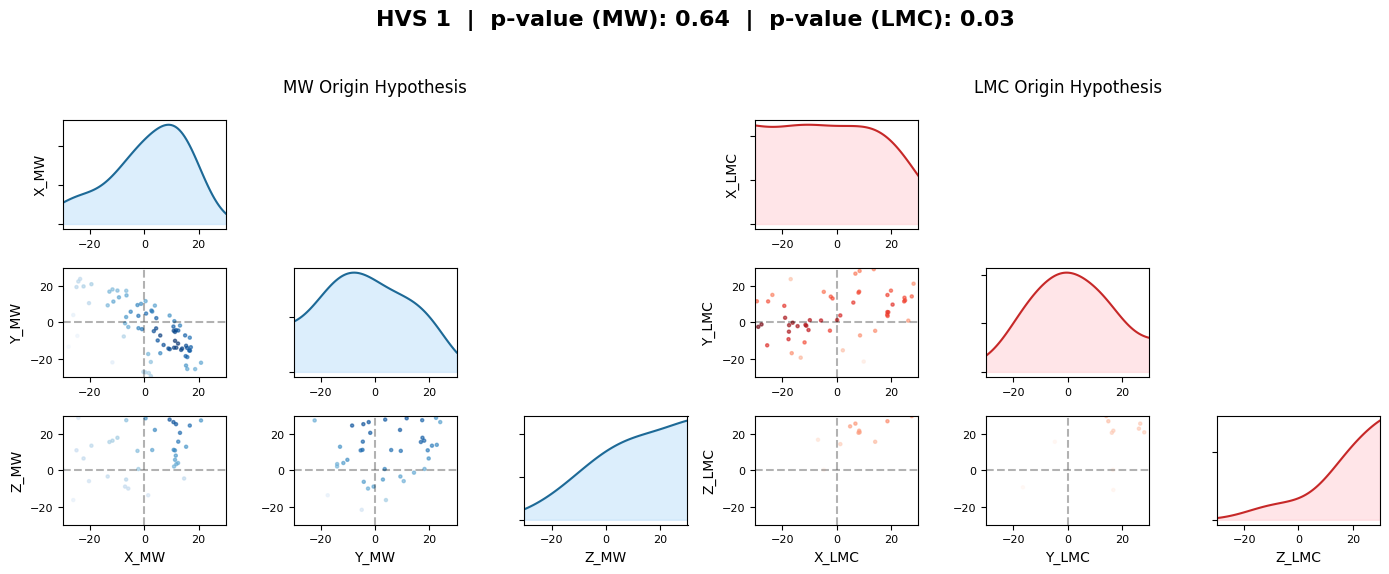

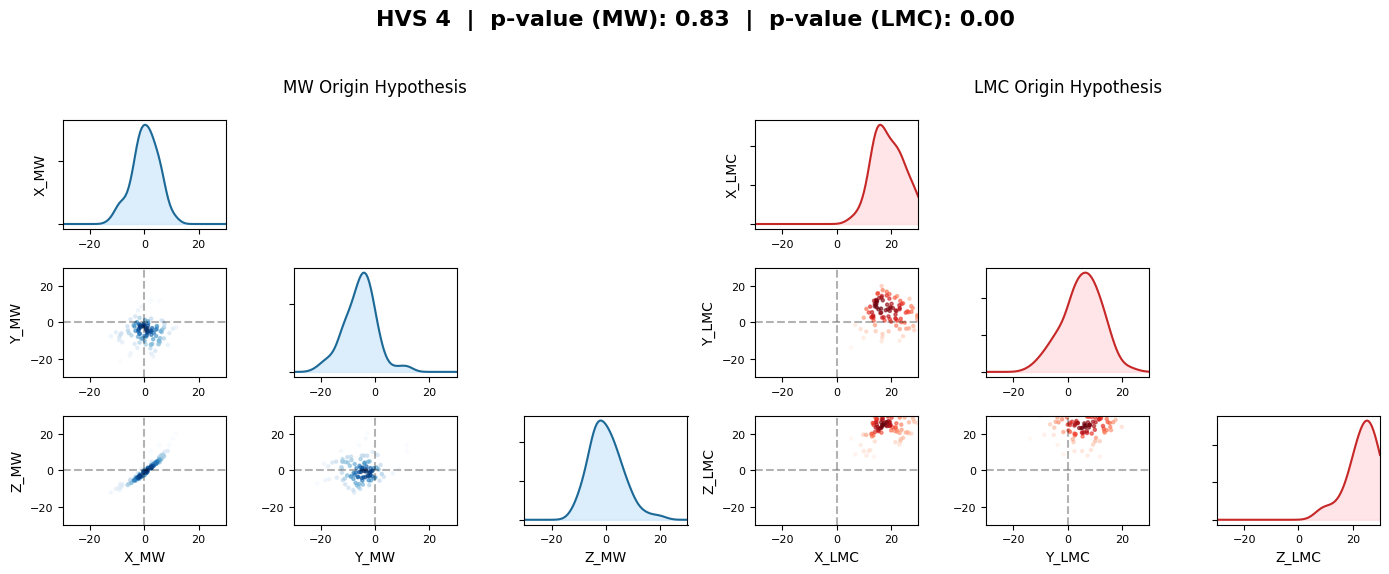

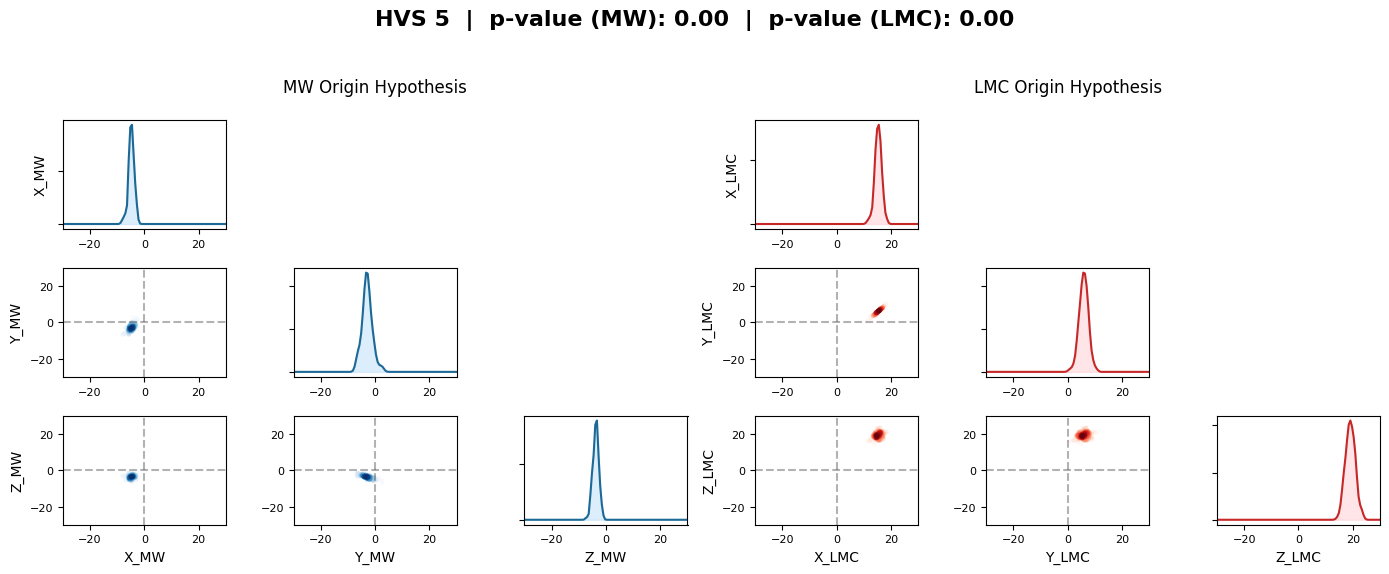

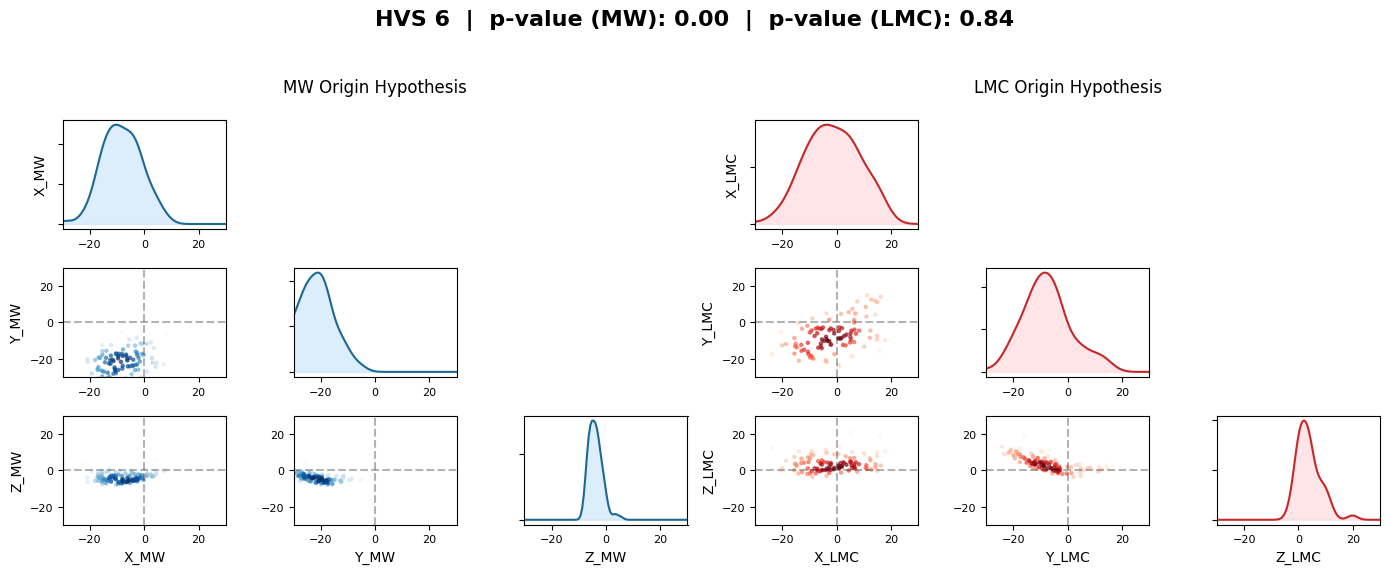

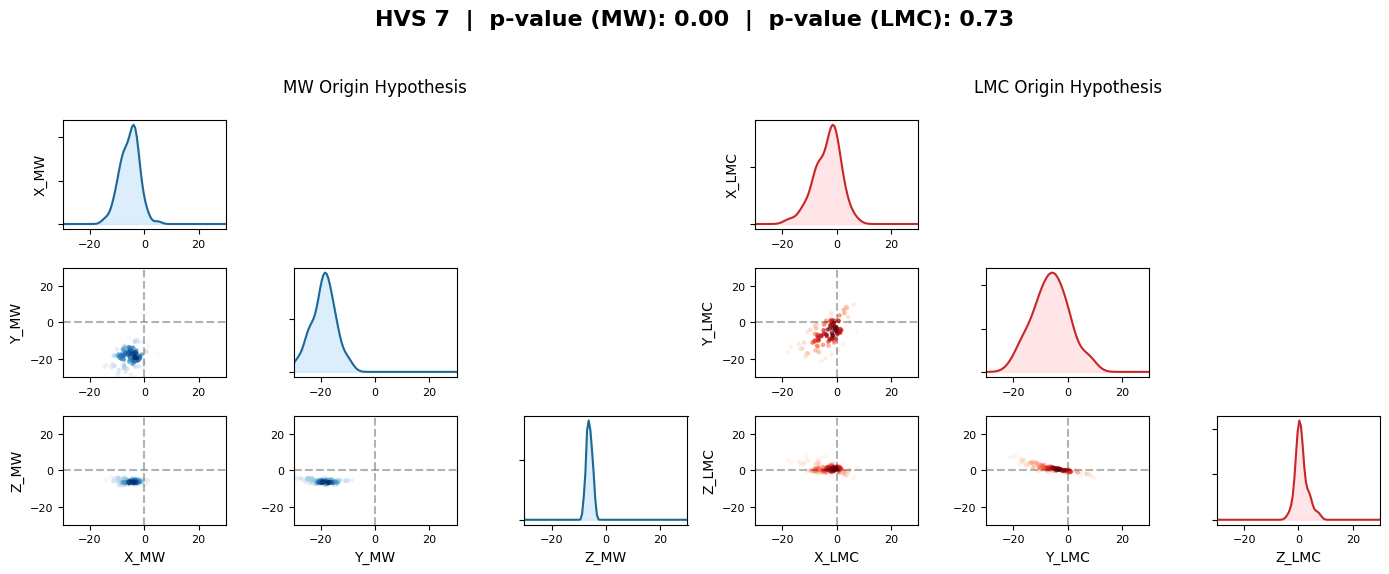

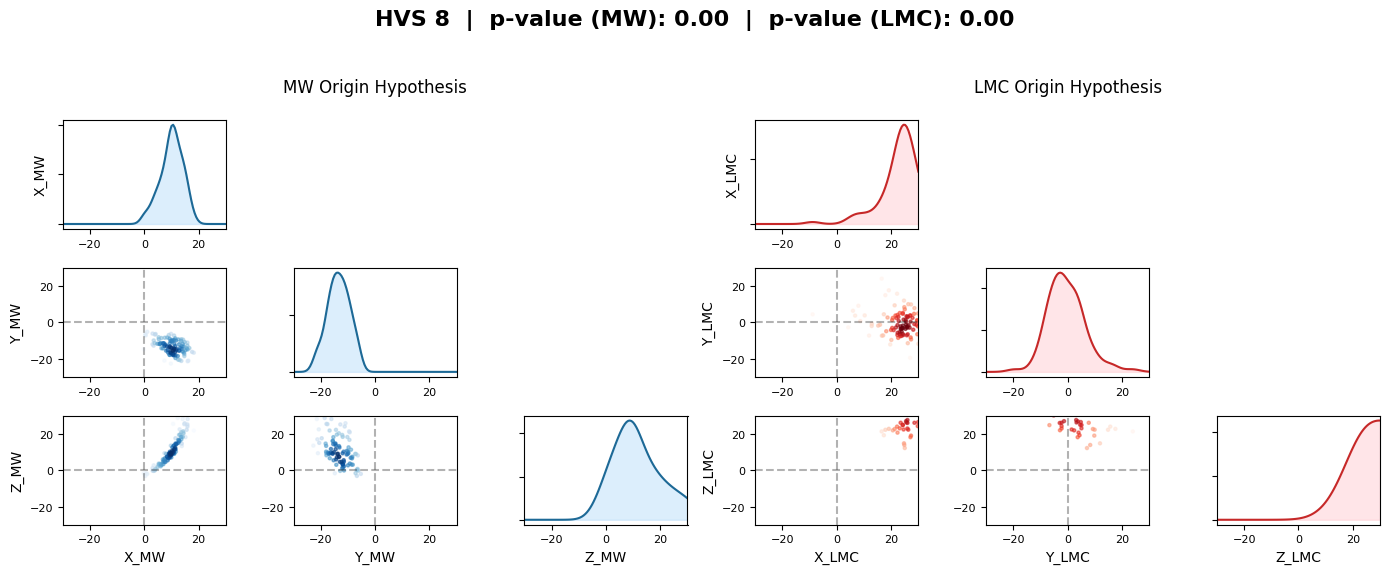

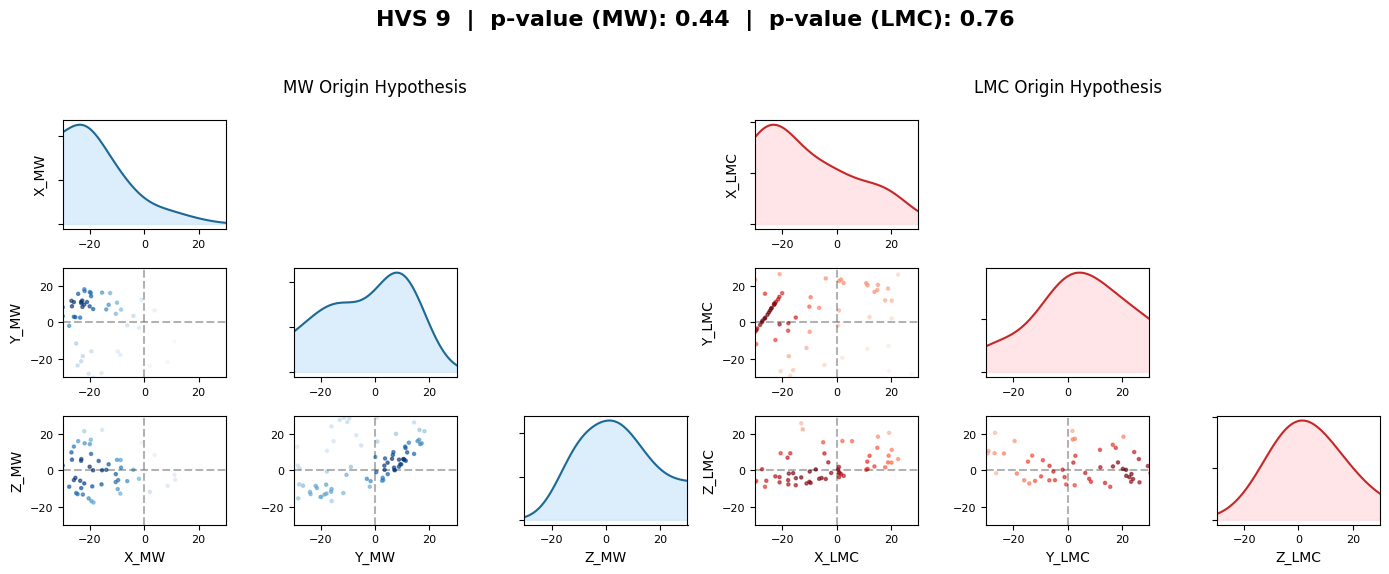

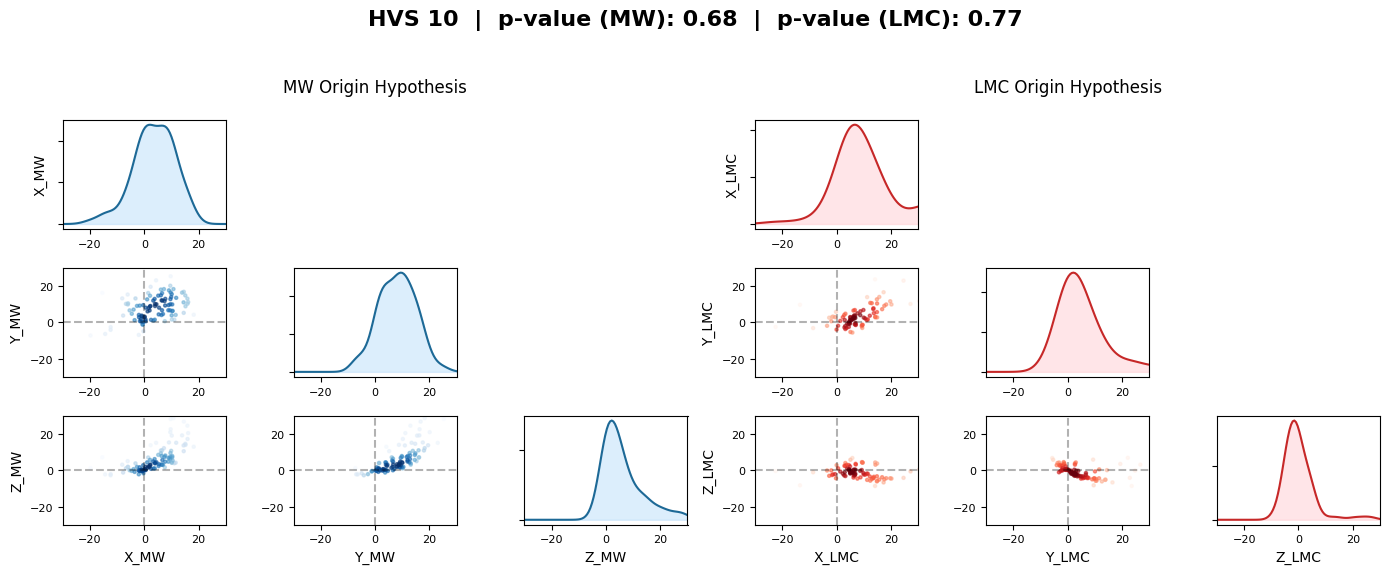

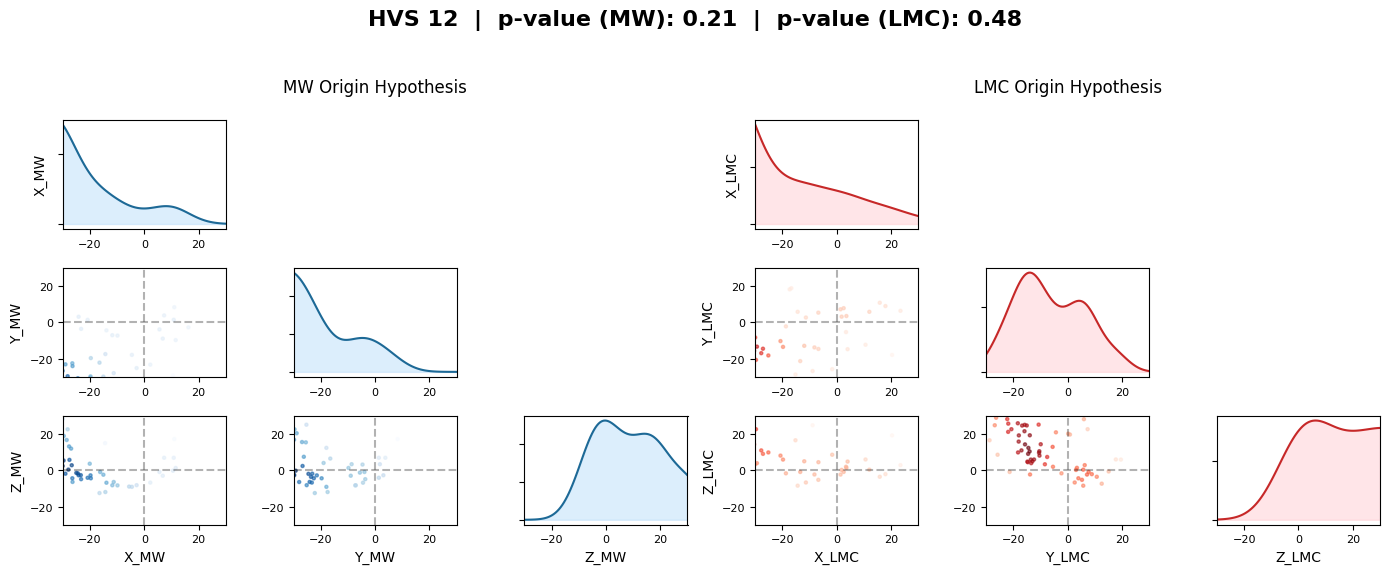

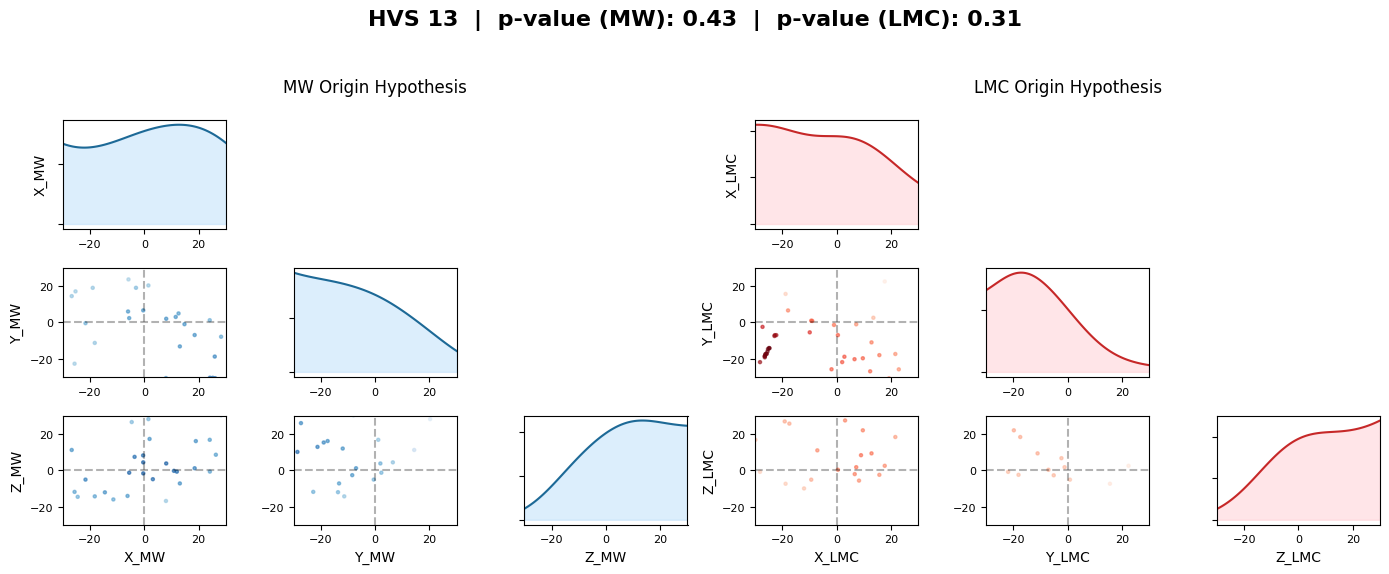

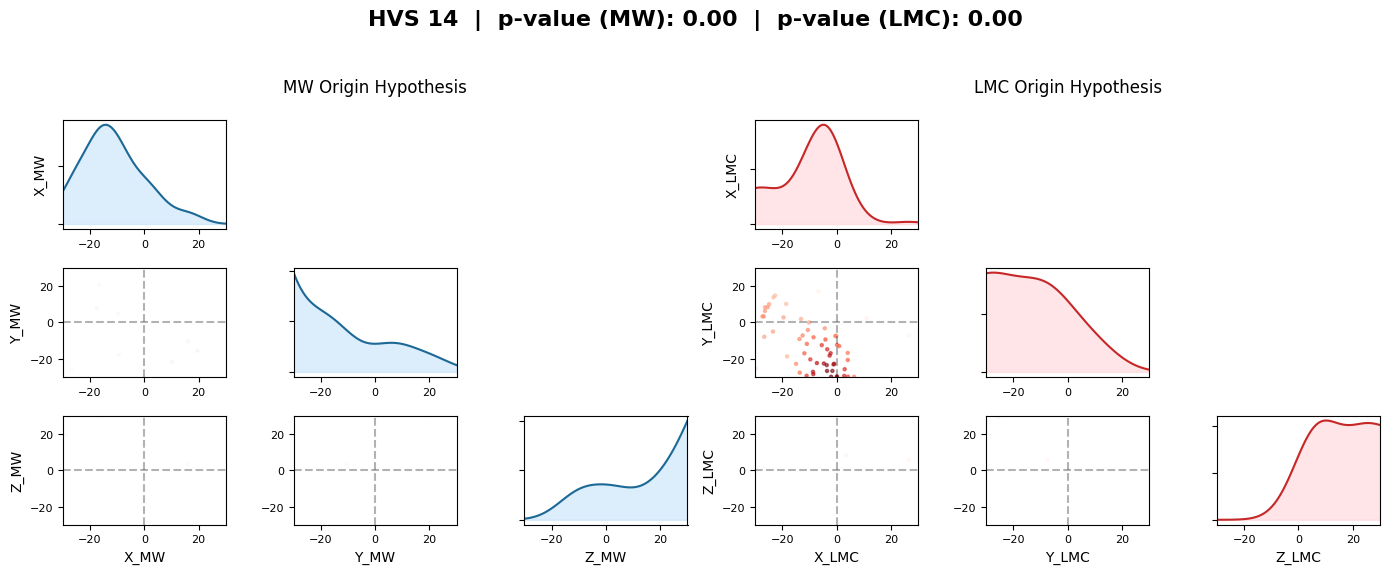

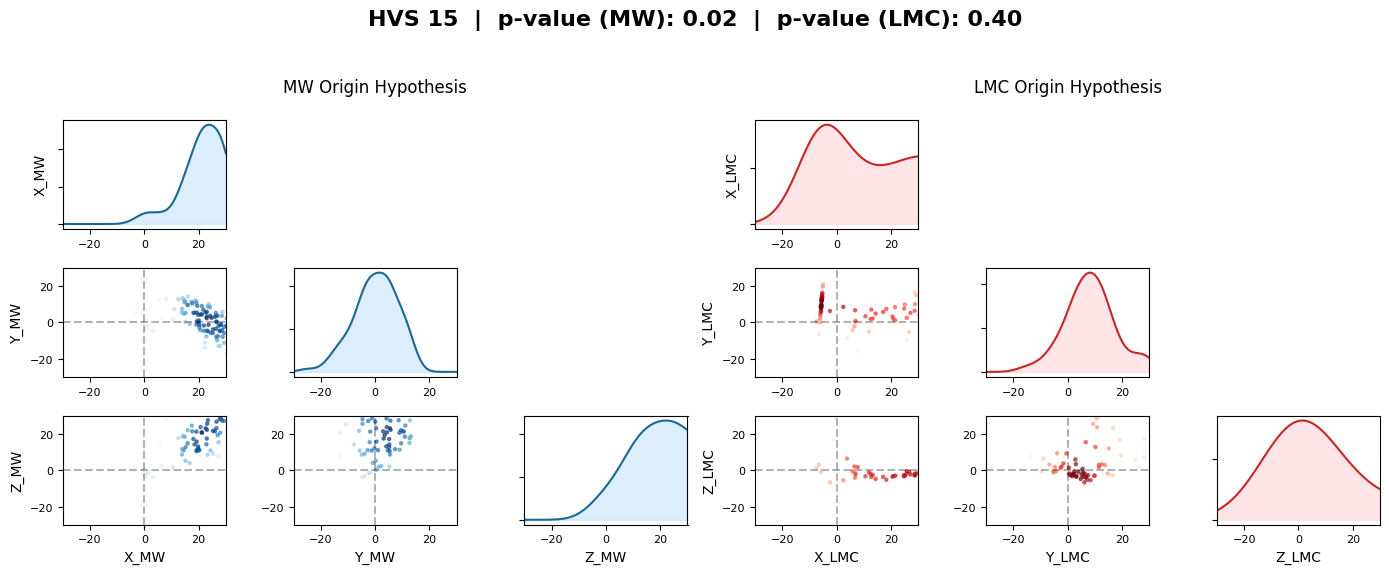

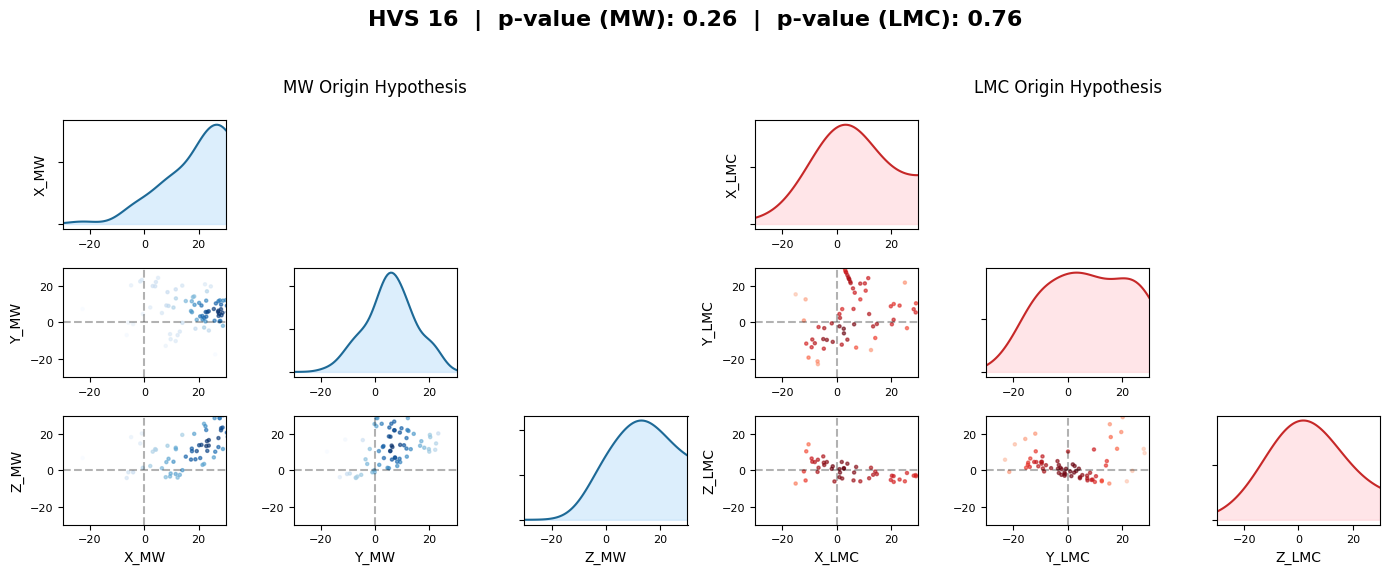

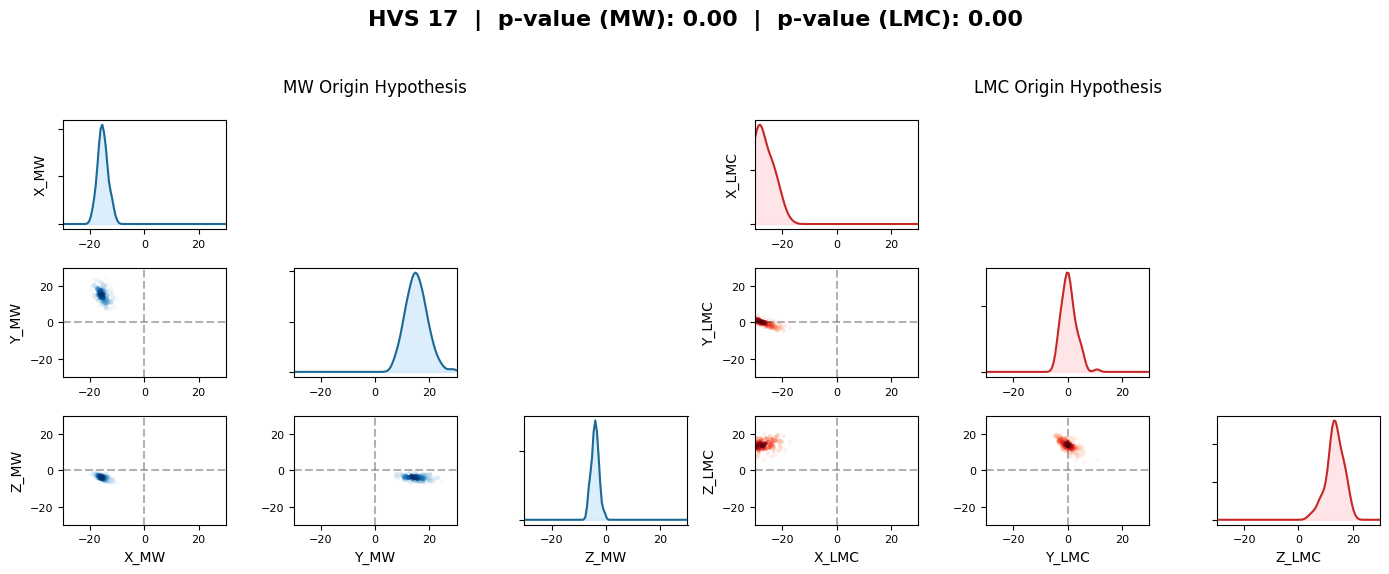

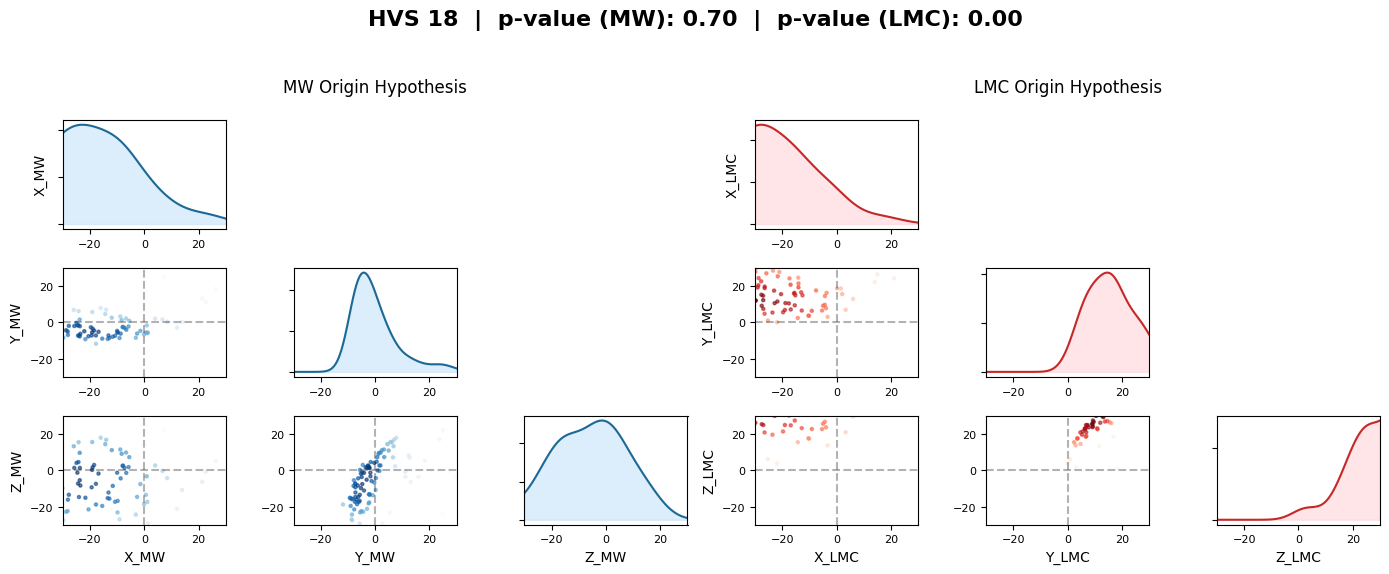

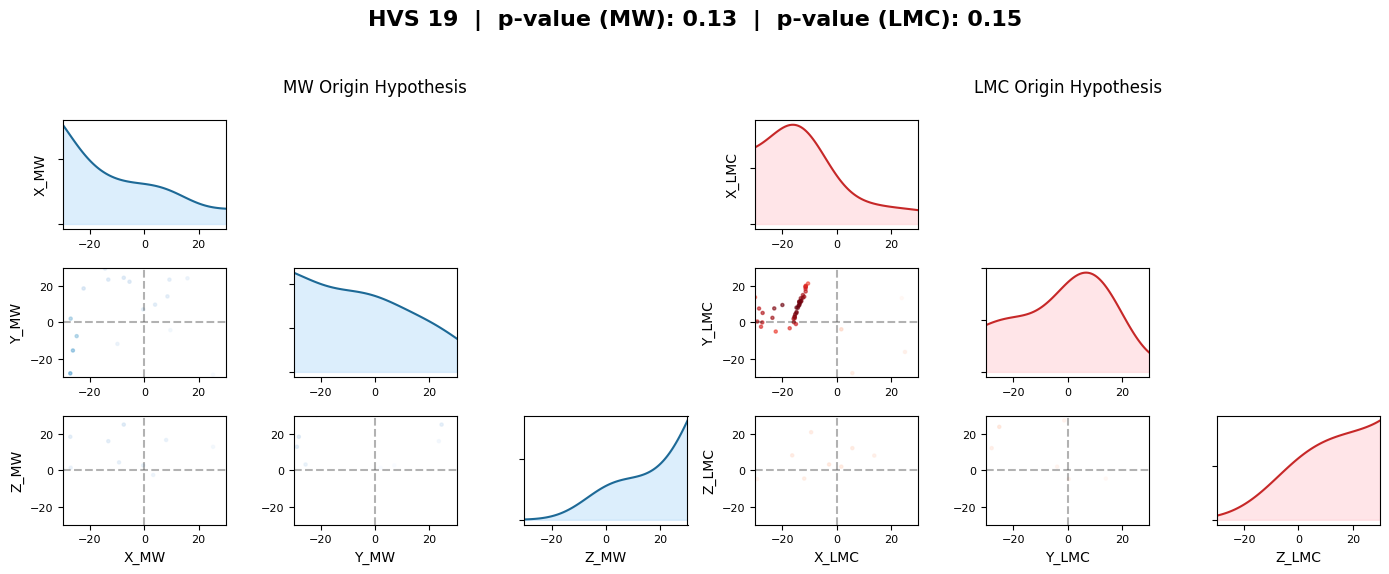

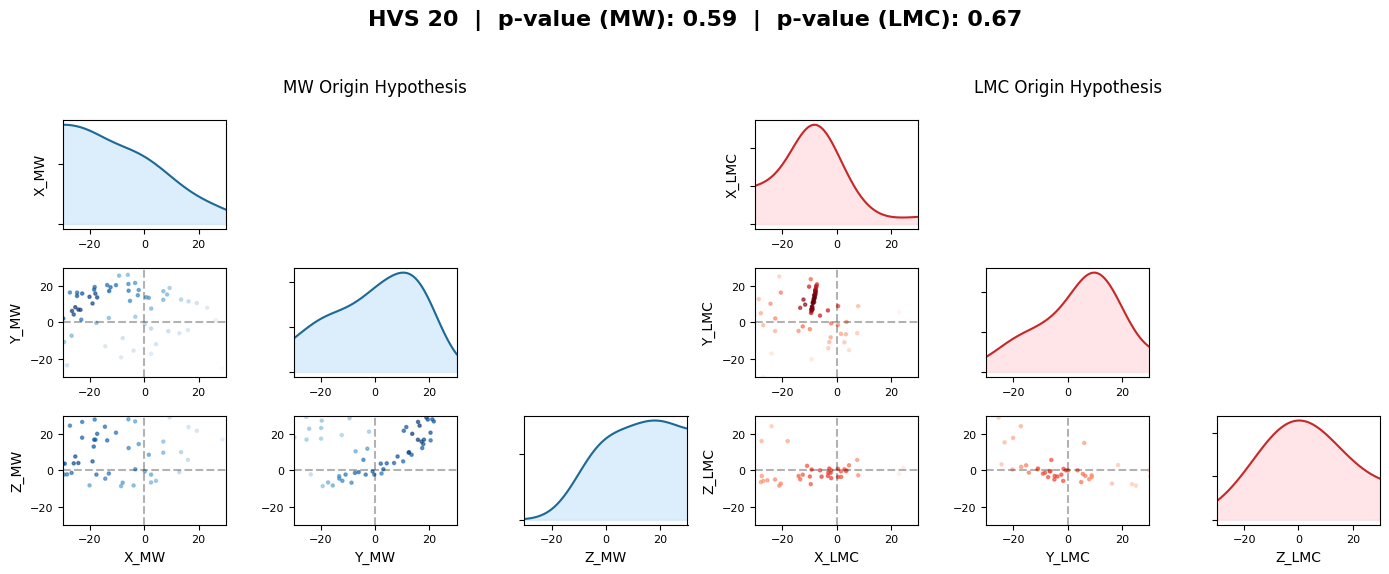

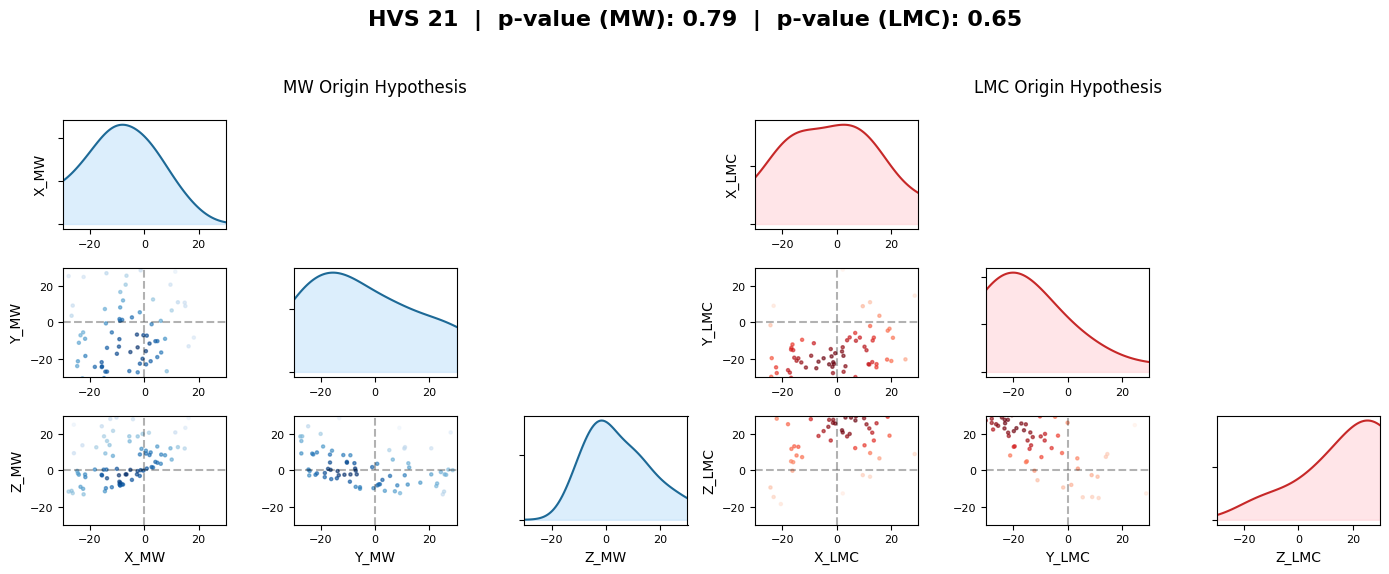

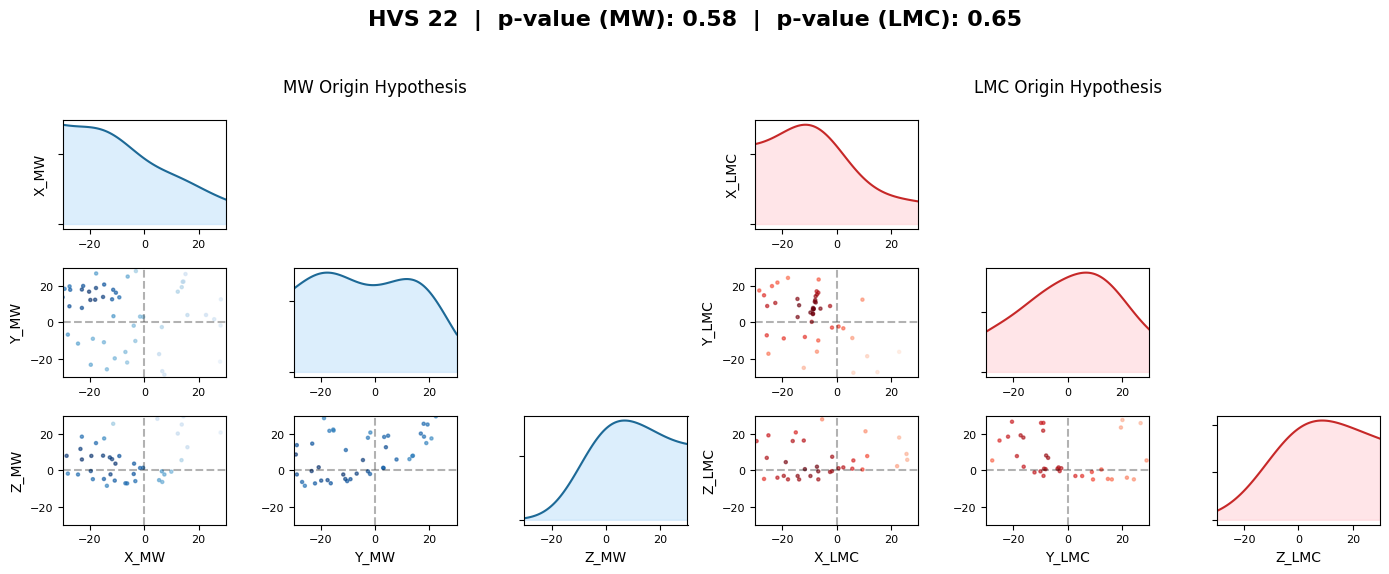

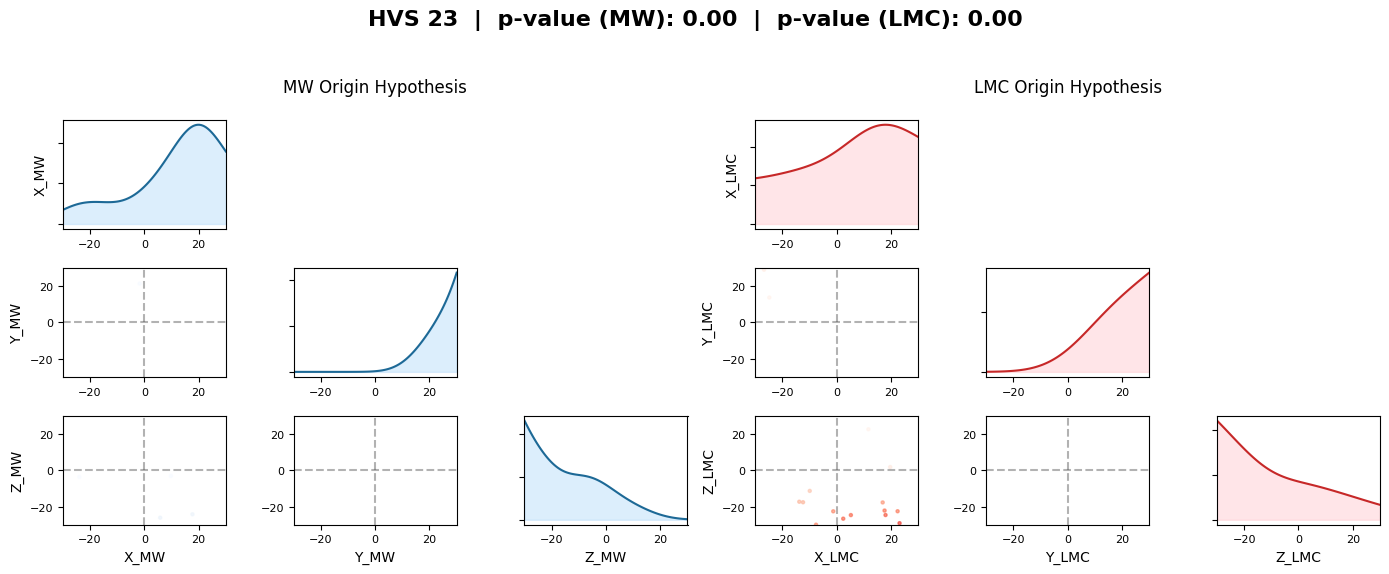

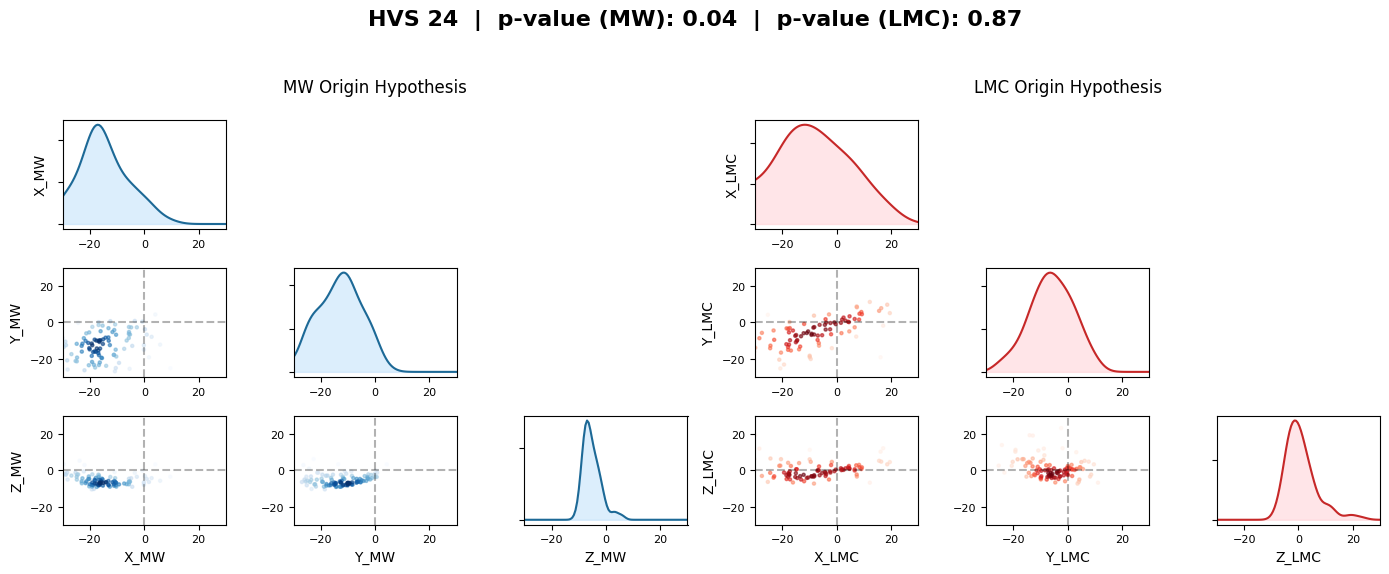

In [14]:
colors = {
    'mw': {'cmap': 'Blues', 'light': '#bbdefb', 'dark': '#1d6996'},
    'lmc': {'cmap': 'Reds', 'light': '#ffcdd2', 'dark': '#c62828'}
}

for result in all_results:
    hvs_id = result['id']
    p_mw = result['p_mw']
    p_lmc = result['p_lmc']
    
    # create a new figure for each HVS with a 3x6 grid of subplots
    fig, axes = plt.subplots(3, 6, figsize=(14, 6))
    fig.suptitle(f"HVS {hvs_id}  |  p-value (MW): {p_mw:.2f}  |  p-value (LMC): {p_lmc:.2f}", 
                 fontsize=16, weight='bold')

    # mw corner plot
    mw_axes = axes[:, :3]
    mw_axes[0, 1].set_title('MW Origin Hypothesis', fontsize=12, pad=20)
    make_corner_plot(fig, mw_axes, result['mw_passages'], 
                     ['X_MW', 'Y_MW', 'Z_MW'], 
                     [(-30, 30)]*3, colors['mw'])

    # lmc corner plot
    lmc_axes = axes[:, 3:]
    lmc_axes[0, 1].set_title('LMC Origin Hypothesis', fontsize=12, pad=20)
    make_corner_plot(fig, lmc_axes, result['lmc_passages'], 
                     ['X_LMC', 'Y_LMC', 'Z_LMC'], 
                     [(-30, 30)]*3, colors['lmc'])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()